In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import sys
import mne
import math
import random
mne.use_log_level('ERROR')
sys.path.append(os.path.join(os.path.dirname("."), '..'))
from data.Benchmark_read_attack import Benchmark_read, Benchmark_attacked_read

In [9]:
samp_rate = 250
sample_time = 4
all_data, labels = Benchmark_read(list(range(1, 6)))
# data, labels = Benchmark_read()
random_samples = np.random.choice(range(all_data.shape[0]), size=100, replace=False)
data = all_data[random_samples, :, :samp_rate*sample_time]
attacked_data, attacked_labels = Benchmark_attacked_read(noise_amp=0.3)
attacked_data = attacked_data[:, :, :samp_rate*sample_time]
data.shape

(100, 9, 1000)

In [10]:
trial = 0
trial_data = data[trial]
attacked_trial_data = attacked_data[trial]
perturbation = attacked_trial_data - trial_data

In [11]:
def delay_signal(signal, time, fs=250):
    pad_width = math.ceil(time*fs/2)
    signal = np.pad(signal, pad_width, 'constant', constant_values=0)
    signal = np.roll(signal, int(time*fs))
    signal = signal[pad_width:(len(signal)-pad_width)]
    return signal

def sin_produce(amplitude = 1, f = 8.3, length = 2*250):   # 振幅, 频率, 初始相位, 数据长度
    # 生成时间序列
    t = np.linspace(0, (length-1)/250, int(length))

    # 生成正弦信号
    sin_signal = np.sin(2*np.pi*f * t) * amplitude

    # sin_signal = delay_signal(sin_signal, random.uniform(0, 0.1))

    return sin_signal


def square_wave_produce(
    fs = 250,           # 采样率
    f = 8.3,            # 信号频率
    dc = 0.5,           # 占空比
    amplitude = 1,      # 幅值
    length = 2*250,     # 方波长度
    unipolar = False):   # 是否是单极方波

    # 生成时间轴
    t = np.linspace(0, (length-1.0)/fs, length)

    # 生成方波
    if unipolar:
        square_wave = np.array(np.where(np.mod(t*f, 1) < dc, 1, 0)) * amplitude
    else:
        square_wave = np.array(np.where(np.mod(t*f, 1) < dc, 1, -1)) * amplitude

    # square_wave = delay_signal(square_wave, random.uniform(0, 0.1))

    return square_wave

def rec_wave_produce(
    fs = 250,           # 采样率
    f = 8.3,            # 信号频率
    dc = 0.2,           # 占空比
    amplitude = 1,      # 幅值
    length = 2*250,     # 方波长度
    unipolar = False):   # 是否是单极方波

    # 生成时间轴
    t = np.linspace(0, (length-1)/fs, length)

    # 生成方波
    if unipolar:
        square_wave = np.where(np.mod(t*f,1) < dc, 1, 0) * amplitude
    else:
        square_wave = np.where(np.mod(t*f,1) < dc, 1, -1) * amplitude

    # square_wave = delay_signal(square_wave, random.uniform(0, 0.1))

    return square_wave


def sawtooth_wave_produce(
    fs = 250,           # 采样率
    f = 8.3,            # 频率
    amplitude = 1,      # 幅值
    length = 2*250):    # 周期数

    # 生成时间轴
    t = np.linspace(0, (length-1)/fs, length, endpoint=False)

    # 生成锯齿波
    sawtooth_wave = 2 * (f*t - np.floor(f*t)-0.5) * amplitude

    # sawtooth_wave = delay_signal(sawtooth_wave, random.uniform(0, 0.1))

    return sawtooth_wave

def plot_matrix(matrix, trial_data, perturbations, title):
    # 使用 matshow 显示数据
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.tight_layout()
    mat = ax.matshow(matrix)
    yticks_labels = [f"EEG Channel{i+1}" for i in range(len(trial_data))]
    yticks_labels += ["sine wave", "square wave", "rectangular wave", "sawtooth wave"]
    ax.set_yticks(ticks=np.arange(len(trial_data) + len(perturbations)))
    ax.set_yticklabels(yticks_labels)
    ax.set_xticks(ticks=np.arange(len(trial_data) + len(perturbations)))
    ax.set_xticklabels(yticks_labels, rotation=90)
    ax.tick_params(axis='x', which='both', bottom=False, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.title.set_position([0.4, 1.05])
    ax.set_title(title, fontsize=28)
    # 创建一个新的 colorbar 轴并设置其位置和大小
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([-0.18, 0.965, 0.25, 0.25])
    # cax.set_aspect('equal')
    # 添加颜色图例到新的轴
    cbar = plt.colorbar(mat, cax=cax)
    cbar.ax.yaxis.set_ticks_position('left')
    plt.savefig(title, dpi=500, bbox_inches='tight')
    plt.show()

sin_perturbation = sin_produce(f = 8, length=trial_data.shape[1])
square_perturbation = square_wave_produce(f = 8, length=trial_data.shape[1])
rec_perturbation = rec_wave_produce(f = 8, length=trial_data.shape[1])
sawtooth_perturbation = sawtooth_wave_produce(f = 8, length=trial_data.shape[1])
perturbations = np.array([sin_perturbation, square_perturbation, rec_perturbation, sawtooth_perturbation])

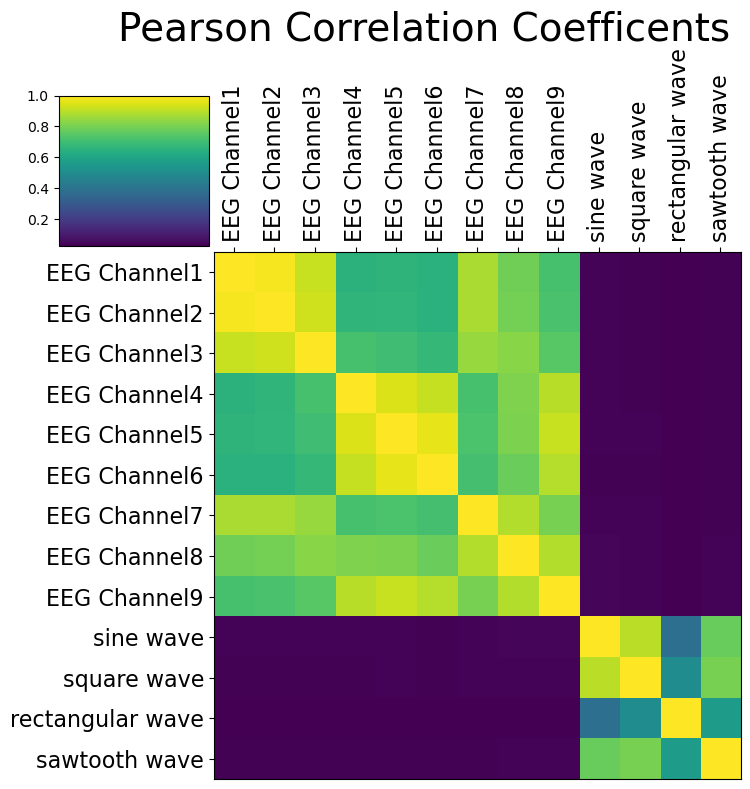

In [12]:
matrix = []
for trial in range(data.shape[0]):
    trial_data = data[trial]
    correlation_matrix = np.corrcoef(trial_data, perturbations)
    matrix.append(correlation_matrix)
plot_matrix(np.mean(np.abs(np.array(matrix)), axis=0), trial_data, perturbations, "Pearson Correlation Coefficents")

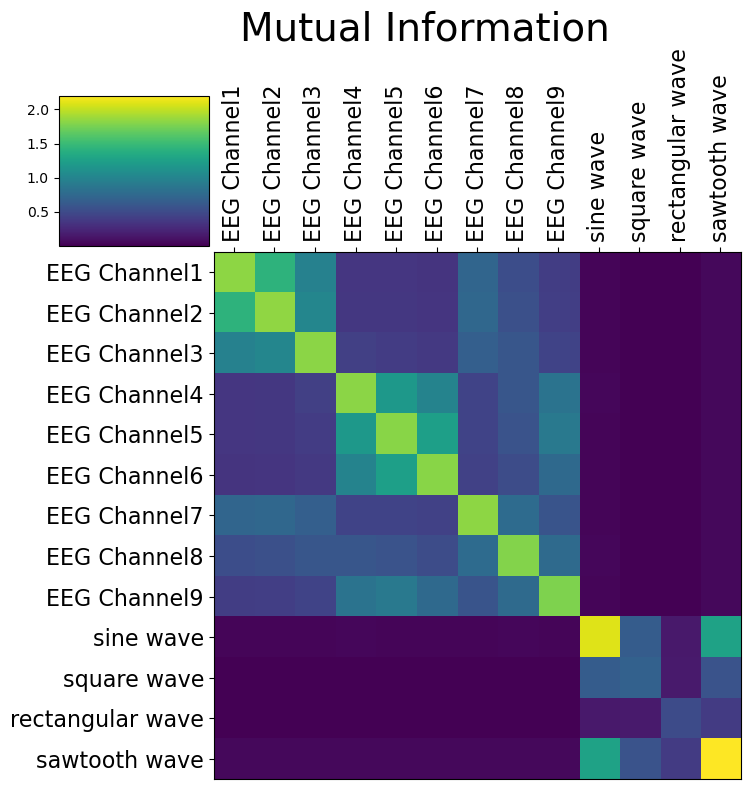

In [13]:
from sklearn.metrics import mutual_info_score

def mutual_information(x, y):
    return mutual_info_score(x, y)

def mutual_info_preprocess(x):
    n_bins=10
    x_binned = np.apply_along_axis(lambda x: np.digitize(x, bins=np.linspace(x.min(), x.max(), n_bins)), 1, x)
    return x_binned

matrix = []
for trial in range(data.shape[0]):
    trial_data = data[trial]
    EEG_perturbation = np.concatenate([trial_data, perturbations], axis=0)
    EEG_perturbation_digitalize = mutual_info_preprocess(EEG_perturbation)

    mi_matrix = np.zeros((EEG_perturbation_digitalize.shape[0], EEG_perturbation_digitalize.shape[0]))
    for i in range(EEG_perturbation_digitalize.shape[0]):
        for j in range(EEG_perturbation_digitalize.shape[0]):
            mi_matrix[i, j] = mutual_information(EEG_perturbation_digitalize[i, :], EEG_perturbation_digitalize[j, :])
    matrix.append(mi_matrix)

plot_matrix(np.mean(np.array(matrix), axis=0), trial_data, perturbations, "Mutual Information")